In [1]:
from time import sleep
import zmq

ctx = zmq.Context()
pupil_remote = zmq.Socket(ctx, zmq.REQ)
pupil_remote.connect('tcp://127.0.0.1:50020')
# start recording
pupil_remote.send_string('R')
print(pupil_remote.recv_string())

sleep(5)
pupil_remote.send_string('r')
print(pupil_remote.recv_string())


OK
OK


In [3]:
import zmq
ctx = zmq.Context()
# The REQ talks to Pupil remote and receives the session unique IPC SUB PORT
pupil_remote = ctx.socket(zmq.REQ)

ip = 'localhost'  # If you talk to a different machine use its IP.
port = 50020  # The port defaults to 50020. Set in Pupil Capture GUI.

pupil_remote.connect(f'tcp://{ip}:{port}')

# Request 'SUB_PORT' for reading data
pupil_remote.send_string('SUB_PORT')
sub_port = pupil_remote.recv_string()

# Request 'PUB_PORT' for writing data
pupil_remote.send_string('PUB_PORT')
pub_port = pupil_remote.recv_string()


[0.5421723900019886, 0.047270543709099555]
[0.5118398854115751, 0.13976758427923985]
[0.5421412313954568, 0.04678677307657575]
[0.5095280471712832, 0.14076585489148985]
[0.5418411546320618, 0.047029619145133816]


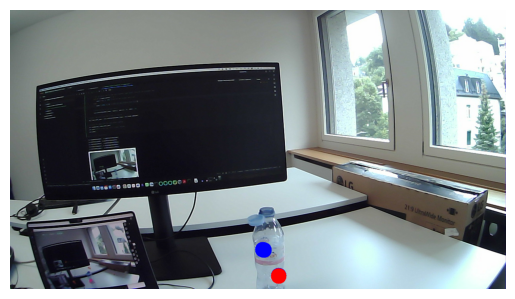

In [62]:
# Assumes `sub_port` to be set to the current subscription port
subscriber = ctx.socket(zmq.SUB)
subscriber.connect(f'tcp://{ip}:{sub_port}')
subscriber.subscribe('gaze.')  # receive all gaze messages

# we need a serializer
import msgpack

# List to store gaze points
gaze_points = []

# for loop 5 times to get 5 gaze messages
for _ in range(5):
    topic, payload = subscriber.recv_multipart()
    message = msgpack.loads(payload)
    gaze = message['norm_pos'.encode()]
    print(gaze)  # Corrected access to 'norm_pos'
    gaze_points.append(gaze)
    
    
# Assumes `sub_port` to be set to the current subscription port
subscriber = ctx.socket(zmq.SUB)
subscriber.connect(f'tcp://{ip}:{sub_port}')
subscriber.subscribe("frame.world")  # receive all frames messages

frame = subscriber.recv_multipart()

# plot the frame frame[2] is the image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming frame[2] contains the image data as a byte buffer
frame_data = frame[2]

# Decode the image from the byte buffer
decoded_frame = cv2.imdecode(np.frombuffer(frame_data, dtype=np.uint8), cv2.IMREAD_COLOR)

# Check if the image was decoded properly
if decoded_frame is None:
    print("Error decoding the image")
else:
    # Convert the color from BGR (OpenCV default) to RGB for proper display with matplotlib
    rgb_frame = cv2.cvtColor(decoded_frame, cv2.COLOR_BGR2RGB)

    # Plot the gaze points
    for i, gaze in enumerate(gaze_points):
        # Ensure the gaze point is within valid bounds (0 to 1)
        if 0 <= gaze[0] <= 1 and 0 <= gaze[1] <= 1:
            # Convert normalized gaze coordinates to pixel coordinates
            # Flip the y-axis as the origin (0, 0) is at the top-left corner in OpenCV
            gaze_x, gaze_y = int(gaze[0] * decoded_frame.shape[1]), int((1 - gaze[1])  * decoded_frame.shape[0])
            
            # Set the color: red for the last (current) gaze point, blue for the previous ones
            if i == len(gaze_points) - 1:
                color = (0, 0, 255)  # Red for the current gaze point
            else:
                color = (255, 0, 0)  # Blue for the previous gaze points
            
            # Draw a circle at the gaze point
            cv2.circle(decoded_frame, (gaze_x, gaze_y), 20, color, -1)
    
    # Convert the color from BGR to RGB for display
    rgb_frame_with_gaze = cv2.cvtColor(decoded_frame, cv2.COLOR_BGR2RGB)
    
    # Display the image with the gaze points overlay
    plt.imshow(rgb_frame_with_gaze)
    plt.axis('off') 
    plt.show()
